# Read dataset

# Install necessary modules

In [ ]:
!pip install transformers torch

# Prepare pytorch's dataset

In [ ]:
from transformers import AutoTokenizer
import json

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("SpanBERT/spanbert-base-cased")

with open('data.json') as json_file:
    dataset = json.load(json_file)

output = []
for data_point in dataset:
    tokens = data_point['tokens']
    labels = data_point['labels']

    # replace, start, inside, and end with their actual values

    for i, label in enumerate(labels):
        end = label.split("-")
        if len(end) == 2:
            labels[i] = end[1]
        else:
            labels[i] = end[0]

    tokenized_tokens = []
    tokenized_labels = []
    tokenized_attention_mask = []

    for i, token in enumerate(tokens):
        tokenized_token = tokenizer(token.split(), is_split_into_words=True)
        tokenized_label = [labels[i]] * len(tokenized_token["input_ids"])

        tokenized_tokens.extend(tokenized_token["input_ids"])
        tokenized_labels.extend(tokenized_label)
        tokenized_attention_mask.extend(tokenized_token["attention_mask"])

    output.append({"tokens": tokenized_tokens, "labels": tokenized_labels, "attention_mask": tokenized_attention_mask})


def chunk_and_pad(output):
    all_json = []
    for data_point in output:
        tokens = data_point["tokens"]

        labels = data_point["labels"]
        attention_mask = data_point["attention_mask"]

        chunked_tokens = []
        chunked_labels = []
        chunked_attention_mask = []

        for i in range(0, len(tokens), 512):
            chunked_tokens.append(tokens[i:i + 512])
            chunked_labels.append(labels[i:i + 512])
            chunked_attention_mask.append(attention_mask[i:i + 512])

        for i in range(len(chunked_tokens)):
            chunked_tokens[i] = chunked_tokens[i] + [0] * (512 - len(chunked_tokens[i]))
            chunked_labels[i] = chunked_labels[i] + ["O"] * (512 - len(chunked_labels[i]))
            chunked_attention_mask[i] = chunked_attention_mask[i] + [0] * (512 - len(chunked_attention_mask[i]))

        print(len(chunked_tokens[0]))

        for i in range(len(chunked_tokens)):
            all_json.append(
                {"tokens": chunked_tokens[i], "labels": chunked_labels[i], "attention_mask": chunked_attention_mask[i]})

    return all_json


all_json = chunk_and_pad(output)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/413 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512


In [ ]:
print(len(all_json))

143


In [ ]:
from torch import nn
import torch
from torch.utils.data import Dataset


class NERDataset(Dataset):
    def __init__(self, data, tokenizer, label_to_id):
        self.data = data
        self.tokenizer = tokenizer
        self.label_to_id = label_to_id

    def __len__(self):
        return len(self.data)

    def chunk_list(self, lst, chunk_size):
        """Yield successive chunks of size chunk_size from lst."""
        for i in range(0, len(lst), chunk_size):
            yield lst[i:i + chunk_size]

    def __getitem__(self, idx):
        item = self.data[idx]

        # Convert labels to IDs
        label_ids = [self.label_to_id.get(label, 0) for label in item['labels']]
        # Ensure label_ids length matches input_ids length

        return {
            "input_ids": torch.tensor(item["tokens"]),
            "attention_mask": torch.tensor(item["attention_mask"]),
            "labels": torch.LongTensor(label_ids)
        }


label_to_id = {'Requirement': 0, 'Exception': 1, 'Selection': 2,
               'Application': 3}

# Initialize the dataset
ner_dataset = NERDataset(all_json, tokenizer, label_to_id)

In [ ]:
print(ner_dataset[0]["labels"])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 3, 3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Train, Validate and Save best model

In [ ]:
!pip install scikit-learn

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import AutoModelForTokenClassification, AutoTokenizer, AdamW
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


# Parameters
num_labels = len(label_to_id)  # Number of labels in your dataset
model_name = "SpanBERT/spanbert-base-cased"

# Model and Tokenizer Initialization
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=num_labels)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Dataset and DataLoader
dataset_size = len(ner_dataset)
train_size = int(0.8 * dataset_size)  # 80% for training
val_size = dataset_size - train_size  # 20% for validation
train_dataset, val_dataset = random_split(ner_dataset, [train_size, val_size])

# Create DataLoader for validation set
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Early Stopping
early_stopping_patience = 30
early_stopping_counter = 0
best_loss = float('inf')

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
train_accuracies = []
train_precisions = []
train_f1s = []
train_recalls = []

val_losses = []
val_accuracies = []
val_precisions = []
val_f1s = []
val_recalls = []

# Training Loop
model.train()
for epoch in range(10):  # Adjust the number of epochs as needed
    total_loss = 0
    all_predictions = []
    all_labels = []

    id_to_label = {v: k for k, v in label_to_id.items()}
    accuracy_per_entity_type = {label: [] for label in id_to_label.values()}

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Convert logits to predictions
        predictions = torch.argmax(logits, dim=2)
        all_predictions.extend(predictions.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

        total_loss += loss.item()


    average_loss = total_loss / len(train_loader)

    train_accuracy = accuracy_score(all_labels, all_predictions)
    train_precision = precision_score(all_labels, all_predictions, average='weighted')
    train_recall = recall_score(all_labels, all_predictions, average='weighted')
    train_f1 = f1_score(all_labels, all_predictions, average='weighted')

    train_losses.append(average_loss)
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_f1s.append(train_f1)
    train_recalls.append(train_recall)

    print(f"Epoch {epoch+1}: Train: Loss = {average_loss}, Accuracy = {train_accuracy}, Precision = {train_precision}, Recall = {train_recall}, F1 = {train_f1}")

  # Validation
    model.eval()
    total_val_loss = 0
    all_val_predictions = []
    all_val_labels = []
    with torch.no_grad():
        for val_batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            input_ids = val_batch['input_ids'].to(device)
            attention_mask = val_batch['attention_mask'].to(device)
            labels = val_batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            # Convert logits to predictions
            val_predictions = torch.argmax(logits, dim=2)
            all_val_predictions.extend(val_predictions.view(-1).cpu().numpy())
            all_val_labels.extend(labels.view(-1).cpu().numpy())

            total_val_loss += loss.item()

    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = accuracy_score(all_val_labels, all_val_predictions)

    val_precision = precision_score(all_val_labels, all_val_predictions, average='weighted')
    val_recall = recall_score(all_val_labels, all_val_predictions, average='weighted')
    val_f1 = f1_score(all_val_labels, all_val_predictions, average='weighted')

    val_losses.append(average_val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_f1s.append(val_f1)
    val_recalls.append(val_recall)

    print(f"Epoch {epoch+1}: Validation: Loss = {average_val_loss}, Accuracy = {val_accuracy}, Precision = {val_precision}, Recall = {val_recall}, F1 = {val_f1}")
    # Reduce LR on plateau
    scheduler.step(average_val_loss)

    # Early Stopping
    if average_val_loss < best_loss:
        print(f"Val loss improved from {best_loss} to {average_val_loss}")
        best_loss = average_val_loss
        early_stopping_counter = 0

        torch.save(model.state_dict(), 'best_model_state_dict.pt')
    else:
        print("Val loss did not improve")
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break
    print()

pytorch_model.bin:   0%|          | 0.00/215M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1: 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Epoch 1: Train: Loss = 0.994410530726115, Accuracy = 0.7266138980263158, Precision = 0.6148448894786788, Recall = 0.7266138980263158, F1 = 0.645054773800628


Validation Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1: Validation: Loss = 0.7955668270587921, Accuracy = 0.7581492456896551, Precision = 0.574790278739793, Recall = 0.7581492456896551, F1 = 0.6538583458133268
Val loss improved from inf to 0.7955668270587921



Training Epoch 2: 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2: Train: Loss = 0.763154665629069, Accuracy = 0.7562534265350878, Precision = 0.5719192451460614, Recall = 0.7562534265350878, F1 = 0.6512946668231143


Validation Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.85it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2: Validation: Loss = 0.7389684915542603, Accuracy = 0.7581492456896551, Precision = 0.574790278739793, Recall = 0.7581492456896551, F1 = 0.6538583458133268
Val loss improved from 0.7955668270587921 to 0.7389684915542603



Training Epoch 3: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3: Train: Loss = 0.7393342693646748, Accuracy = 0.7562534265350878, Precision = 0.5719192451460614, Recall = 0.7562534265350878, F1 = 0.6512946668231143


Validation Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3: Validation: Loss = 0.7228142395615578, Accuracy = 0.7581492456896551, Precision = 0.574790278739793, Recall = 0.7581492456896551, F1 = 0.6538583458133268
Val loss improved from 0.7389684915542603 to 0.7228142395615578



Training Epoch 4: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4: Train: Loss = 0.7304958899815878, Accuracy = 0.7562534265350878, Precision = 0.5719192451460614, Recall = 0.7562534265350878, F1 = 0.6512946668231143


Validation Epoch 4: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4: Validation: Loss = 0.7133013680577278, Accuracy = 0.7581492456896551, Precision = 0.574790278739793, Recall = 0.7581492456896551, F1 = 0.6538583458133268
Val loss improved from 0.7228142395615578 to 0.7133013680577278



Training Epoch 5: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5: Train: Loss = 0.7239904304345449, Accuracy = 0.7562534265350878, Precision = 0.5719192451460614, Recall = 0.7562534265350878, F1 = 0.6512946668231143


Validation Epoch 5: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5: Validation: Loss = 0.7070348933339119, Accuracy = 0.7581492456896551, Precision = 0.574790278739793, Recall = 0.7581492456896551, F1 = 0.6538583458133268
Val loss improved from 0.7133013680577278 to 0.7070348933339119



Training Epoch 6: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6: Train: Loss = 0.7142528335253397, Accuracy = 0.7562534265350878, Precision = 0.5719192451460614, Recall = 0.7562534265350878, F1 = 0.6512946668231143


Validation Epoch 6: 100%|██████████| 4/4 [00:00<00:00,  4.53it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6: Validation: Loss = 0.6998867020010948, Accuracy = 0.7581492456896551, Precision = 0.574790278739793, Recall = 0.7581492456896551, F1 = 0.6538583458133268
Val loss improved from 0.7070348933339119 to 0.6998867020010948



Training Epoch 7: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7: Train: Loss = 0.6983480115731557, Accuracy = 0.7562534265350878, Precision = 0.5719192451460614, Recall = 0.7562534265350878, F1 = 0.6512946668231143


Validation Epoch 7: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7: Validation: Loss = 0.6981254145503044, Accuracy = 0.7581492456896551, Precision = 0.574790278739793, Recall = 0.7581492456896551, F1 = 0.6538583458133268
Val loss improved from 0.6998867020010948 to 0.6981254145503044



Training Epoch 8: 100%|██████████| 15/15 [00:10<00:00,  1.40it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8: Train: Loss = 0.6673112531503042, Accuracy = 0.7562534265350878, Precision = 0.5719192451460614, Recall = 0.7562534265350878, F1 = 0.6512946668231143


Validation Epoch 8: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8: Validation: Loss = 0.6828589364886284, Accuracy = 0.7581492456896551, Precision = 0.574790278739793, Recall = 0.7581492456896551, F1 = 0.6538583458133268
Val loss improved from 0.6981254145503044 to 0.6828589364886284



Training Epoch 9: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9: Train: Loss = 0.6391535043716431, Accuracy = 0.7706962719298246, Precision = 0.6874373361399464, Recall = 0.7706962719298246, F1 = 0.7149953664809304


Validation Epoch 9: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9: Validation: Loss = 0.7919974103569984, Accuracy = 0.7581492456896551, Precision = 0.574790278739793, Recall = 0.7581492456896551, F1 = 0.6538583458133268
Val loss did not improve



Training Epoch 10: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10: Train: Loss = 0.6751312990983327, Accuracy = 0.7446032072368421, Precision = 0.6650438867147598, Recall = 0.7446032072368421, F1 = 0.6873329760020975


Validation Epoch 10: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


Epoch 10: Validation: Loss = 0.6989736929535866, Accuracy = 0.7581492456896551, Precision = 0.574790278739793, Recall = 0.7581492456896551, F1 = 0.6538583458133268
Val loss did not improve



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
!pip install matplotlib

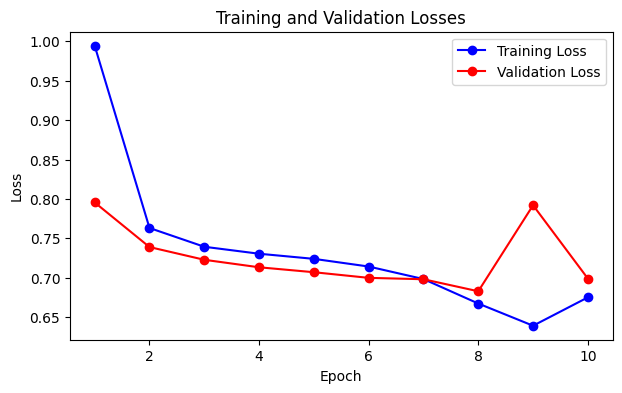

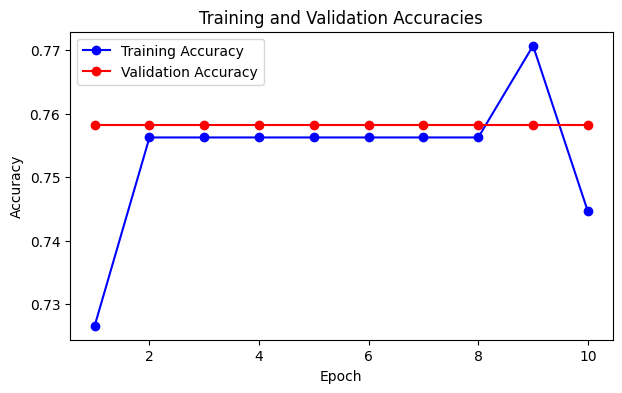

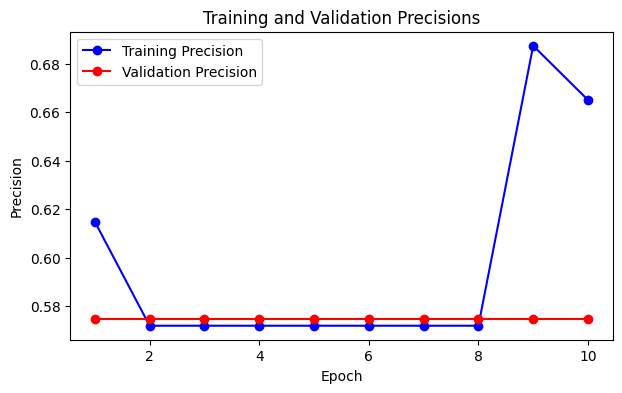

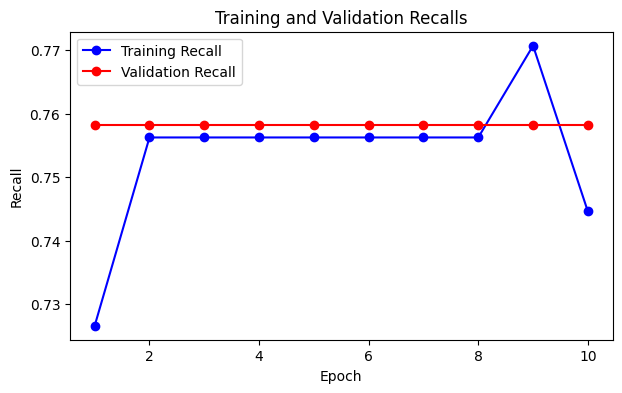

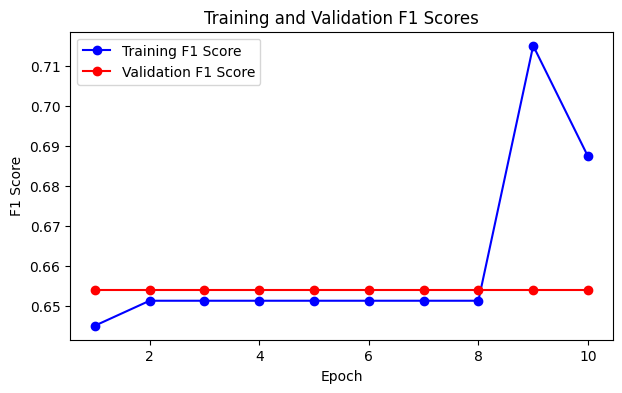

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

def ploty(title, title_plural, train_values, val_values, epochs):
    plt.figure(figsize=(7, 4))
    plt.plot(epochs, train_values, 'bo-', label=f'Training {title}')
    plt.plot(epochs, val_values, 'ro-', label=f'Validation {title}')
    plt.title(f'Training and Validation {title_plural}')
    plt.xlabel('Epoch')
    plt.ylabel(title)
    plt.legend()
    plt.show()

# Plotting training and validation losses
ploty(
    title="Loss",
    title_plural = "Losses",
    train_values = train_losses,
    val_values = val_losses,
    epochs = epochs
)


ploty(
    title="Accuracy",
    title_plural = "Accuracies",
    train_values = train_accuracies,
    val_values = val_accuracies,
    epochs = epochs
)


ploty(
    title="Precision",
    title_plural = "Precisions",
    train_values = train_precisions,
    val_values = val_precisions,
    epochs = epochs
)

ploty(
    title="Recall",
    title_plural = "Recalls",
    train_values = train_recalls,
    val_values = val_recalls,
    epochs = epochs
)

ploty(
    title="F1 Score",
    title_plural = "F1 Scores",
    train_values = train_f1s,
    val_values = val_f1s,
    epochs = epochs
)

# Test the model

In [ ]:
import torch
from transformers import AutoTokenizer
import torch.nn.functional as F
from transformers import AutoModelForTokenClassification, AutoTokenizer, AdamW

# Load the trained model and tokenizer
model_name = "SpanBERT/spanbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

label_to_id = {'Requirement': 0, 'Exception': 1, 'Selection': 2,
               'Application': 3}
id_to_label = {v: k for k, v in label_to_id.items()}


# Function to test the model on new text
def test_model(text):
    # Tokenize the input text
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=512)

    model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=4)
    state_dict = torch.load('best_model_state_dict.pt')
    model.load_state_dict(state_dict)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Move tensors to the same device as the model
    input_ids = inputs["input_ids"].to(model.device)
    attention_mask = inputs["attention_mask"].to(model.device)

    # Model inference
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    # Apply softmax to the model output to get probabilities
    predictions = F.softmax(outputs.logits, dim=-1)

    # Get the most likely class for each token
    predicted_indices = torch.argmax(predictions, dim=-1)
    predicted_indices = predicted_indices.cpu().numpy()

    # Convert predicted indices to class names
    # Assuming you have a dictionary `id_to_label` mapping label IDs to label names
    predicted_labels = [[id_to_label[idx] for idx in indices] for indices in predicted_indices]

    return predicted_labels

# Example usage
text = "Regarding the performance of wall linings, a wall includes: the internal surface of internal and external glazing (except glazing in doors)any part of a ceiling that slopes at an angle greater than 70o to the horizontalHowever"
predicted_labels = test_model(text)  # Assuming test_model returns token-level labels

# Tokenize the text
inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=512)
input_ids = inputs["input_ids"][0]

# Decode each token ID and pair it with its predicted label
decoded_tokens_with_labels = []
for idx, token_id in enumerate(input_ids):
    token = tokenizer.decode(token_id, skip_special_tokens=False)
    if token not in tokenizer.all_special_tokens:
        # Get the label for the token
        label = predicted_labels[0][idx] if idx < len(predicted_labels[0]) else 'O'
        if str(label).strip() == "O":
          label = ""
        else:
          label = f" ({label})"
        decoded_tokens_with_labels.append(f"{token}{label}")

# Create the formatted string
formatted_text = ' '.join(decoded_tokens_with_labels)
print(formatted_text)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


regarding (Requirement) the (Requirement) performance (Requirement) of (Requirement) wall (Requirement) lining (Requirement) ##s (Requirement) , (Requirement) a (Requirement) wall (Requirement) includes (Requirement) : (Requirement) the (Requirement) internal (Requirement) surface (Requirement) of (Requirement) internal (Requirement) and (Requirement) external (Requirement) g (Requirement) ##la (Requirement) ##zing (Requirement) ( (Requirement) except (Requirement) g (Requirement) ##la (Requirement) ##zing (Requirement) in (Requirement) doors (Requirement) ) (Requirement) any (Requirement) part (Requirement) of (Requirement) a (Requirement) ceiling (Requirement) that (Requirement) slopes (Requirement) at (Requirement) an (Requirement) angle (Requirement) greater (Requirement) than (Requirement) 70 (Requirement) ##o (Requirement) to (Requirement) the (Requirement) horizontal (Requirement) ##how (Requirement) ##ever (Requirement)


In [ ]:
# Example usage
text = "In certain conditions, typically classrooms, a single direction of escape (a dead end condition) can be accepted as providing reasonable safety providing that the recommendations of Table 1 on travel distances in a single direction is met and the occupancy of the space is limited to 60. Where travel is possible in one direction only (m) Where travel is possible in more than one direction (m) Places of special fire hazard 1 9 1 1 18 1 Areas with seating in rows 1 15 1 1 32 1 Areas not listed above 1 18 1 1 45 1"
predicted_labels = test_model(text)  # Assuming test_model returns token-level labels

print(predicted_labels)
# Tokenize the text
inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=512)
input_ids = inputs["input_ids"][0]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[['Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Requirement', 'Require